In [6]:
import numpy as np
import matplotlib.pyplot as plt


In [7]:
N = 10
l = 10
rhow = 10**3
rhois = 913
n = 3
R = 8.31446261815324  # J/mol/K
g = 9.82
sec_per_year = 365.25 * 24 * 60 * 60
#tunable parameters
a = 2
b = 3

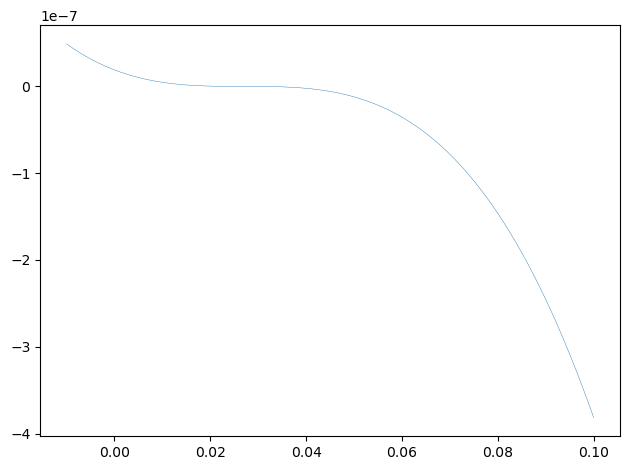

In [47]:
def r_fun(a, b):
    return 2 / (3 * a) + 3 / (2 * b)
def A_fun(T):
    A1 = 3.985e-13 * np.exp(-60e3 / (R * T))
    A2 = 1.916e3 * np.exp(-139e3 / (R * T))
    return np.maximum(A1, A2)
def a_fun(rho):
    # zwinger 2007
    r = rho / rhois
    a1 = np.exp(13.22240 - 15.78652 * r)
    a2 = (1 + (2 / 3) * (1 - r)) * (r ** (-1.5))  # assuming n=3
    return np.where(r < 0.81, a1, a2) # selects a1 if r< 0.81 else it returns a2


def b_fun(rho):  # note the factor 3 difference between zwinger and JL
    r = rho / rhois
    b1 = np.exp(15.09371 - 20.46489 * r)
    b2 = 0.75 * ( ((1 - r) ** (1 / 3)) / (3 * (1 - (1 - r) ** (1 / 3) ) ) ) ** (
        1.5
    )  # assuming n=3
    return np.where(r < 0.81, b1, b2) / 3

def closed_form_cubic_root(k3, k2, k1, k0):
    # https://medium.com/@mephisto_Dev/solving-cubic-equation-using-cardanos-method-with-python-9465f0b92277
    p = (3 * k3 * k1 - k2**2) / (3 * k3**2)
    q = (2 * k2**3 - 9 * k3 * k2 * k1 + 27 * k3**2 * k0) / (27 * k3**3)
    delta = q**2 / 4 + p**3 / 27
    if delta < 0 and delta > -1*1e-10:
        delta = 0
    assert delta>=0, 'no complex root allowed'
    u = np.cbrt(-q / 2 + np.emath.sqrt(delta))
    v = np.cbrt(-q / 2 - np.emath.sqrt(delta))
    # print(f"p {p}, q {q}, u {u}, v {v}, delta {delta}")
    return u + v - k2 / (3 * k3)

def Modified_gagliardini_ezz(sigma_zz, a, b, A, e1=0, e2=0):
    # assuming e1=0 and e2=0
    # assuming n=3 (and no additional linear term in the rheology!)
    if b == 0:
        return -e1 - e2
    r = r_fun(a, b)
    p = (e1 + e2) / (3 * a) - 3 * (e1 + e2) / (2 * b)
    Asig3 = A * sigma_zz**3
    k0 = (
        Asig3 * ((e1**2 + e2**2 - e1 * e2) / (3 * a) + 3 * (e1 + e2) ** 2 / (4 * b))
        + p**3
    )

    k1 = -p * Asig3 - 3 * p**2 * r
    k2 = 0.5 * r * Asig3 + 3 * p * r**2
    k3 = -(r**3)
    # print(f'k3- {k3}, k2-{k2}, k1-{k1}, k0-{k0}')
    return compute_delta(k3,k2,k1,k0)

# ks = Modified_gagliardini_ezz(sigma_zz=-91700, a = a_fun(500), b = b_fun(500), e1=-5e-2, e2=2e-2, A = A_fun(273-30))
# x = np.linspace(-0.01, 0.1, 1000)

def compute_delta(k3,k2,k1,k0):
    p = (3 * k3 * k1 - k2**2) / (3 * k3**2)
    q = (2 * k2**3 - 9 * k3 * k2 * k1 + 27 * k3**2 * k0) / (27 * k3**3)
    delta = q**2 / 4 + p**3 / 27
    return delta


def cubic_eq(x,a,b,c,d):

    return a*x**3 +b*x**2 + c*x + d
y = cubic_eq(x,ks[0], ks[1], ks[2], ks[3])
fig, ax = plt.subplots()
ax.plot(x, y, linewidth = 0.3)
plt.tight_layout()


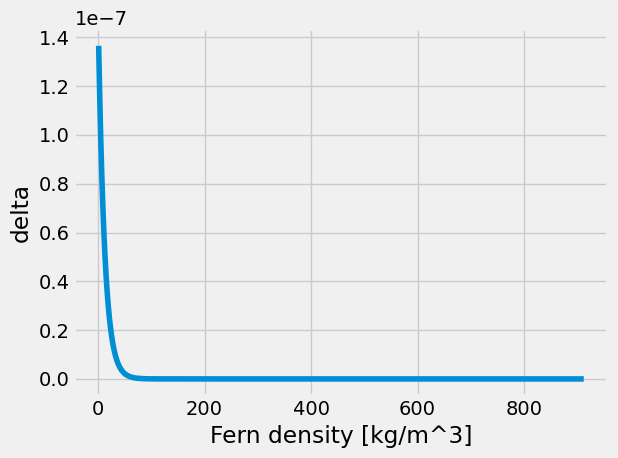

In [67]:
a = [a_fun(i) for i in np.arange(1, 913)]
b = [b_fun(i) for i in np.arange(1, 913)]
delta = [Modified_gagliardini_ezz(sigma_zz=2000, a=a[i], b=b[i], e1=-5, e2=2, A=A_fun(273 - 30)) for i in
         range(len(a))]

# e_sum_array= np.arange(-1000, 1000)
# DeltaRange = np.zeros((2000,912))
# for j in range(len(e_sum_array)):
#     TwoDelta =   [Modified_gagliardini_ezz(sigma_zz=-9170, a=a[i], b=b[i], e1=e_sum_array[j], e2=e_sum_array[j], A=A_fun(273 - 30)) for i in range(len(a))]
#     DeltaRange[j,:] = TwoDelta
Delta = np.array(delta)
plt.style.use('fivethirtyeight')
plt.plot(np.arange(1, 913), Delta)
plt.xlabel(f'Fern density [kg/m^3]')
plt.ylabel('delta')
plt.tight_layout()



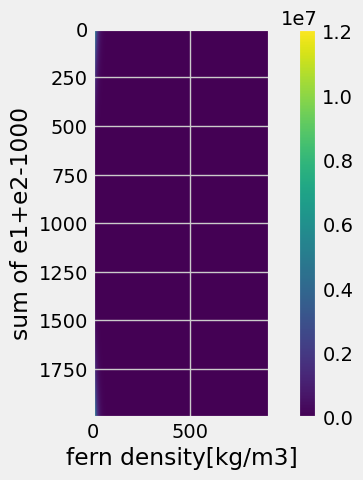

In [60]:
plt.imshow(DeltaRange)
plt.xlabel('fern density[kg/m3]')
plt.ylabel('sum of e1+e2-1000')
plt.colorbar()